# 1. Graph partition

In [1]:
# Install community and  python-louvain for louvain library
!pip install python-louvain community cdlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.9 MB/s eta 0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 81.2 MB/s eta 0:00:000m eta 0:00:01:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.1 MB/s eta 0:00:006.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.5 MB/s eta 0:00:000m eta 0:00:01
Using cached texttable-1.7.0-py2.py3-none-any.whl (10 kB)
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=93

## 1.1. A partition of a graph is a separation of its nodes into disjoint groups. Consider the following graph:



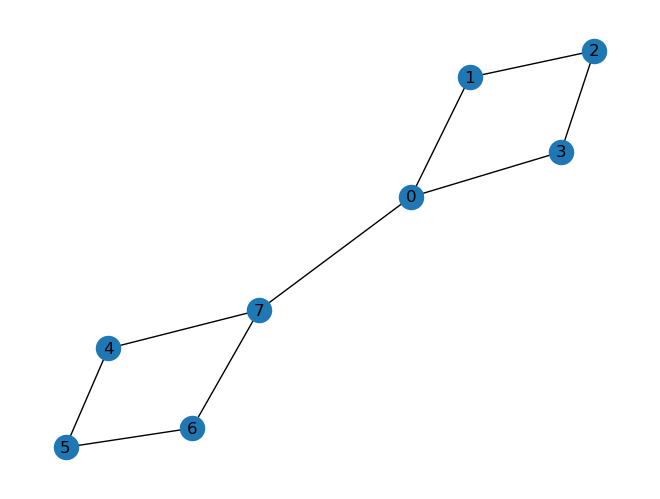

In [5]:
#Construct a graph
import networkx as nx
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

#draw the graph
nx.draw(G, with_labels=True)

## 1.2. Define a partition for graph

In [6]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

## 1.3. Check community is a partition or not

In [7]:
nx.community.is_partition(G, partition)

True

## 1.4. Map nodes to partition

In [8]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}

## 1.5. Check two nodes in the same partition?

In [9]:
partition_map[0] == partition_map[7]


True

## 1.6. Colourize each partition of the graph

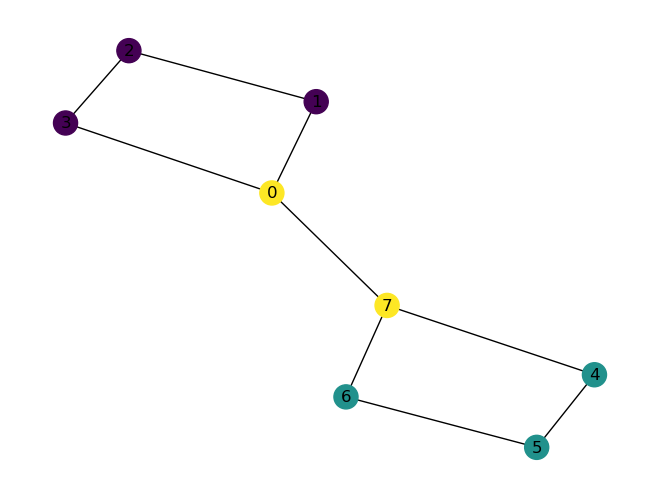

In [10]:
node_colors = [partition_map[n] for n in G.nodes]
        
nx.draw(G, node_color=node_colors, with_labels=True)

# 2. Modularity

## 2.1. In the Community library, the module modularity is a greedy modularity. Let's compare the manual Modularity with the library

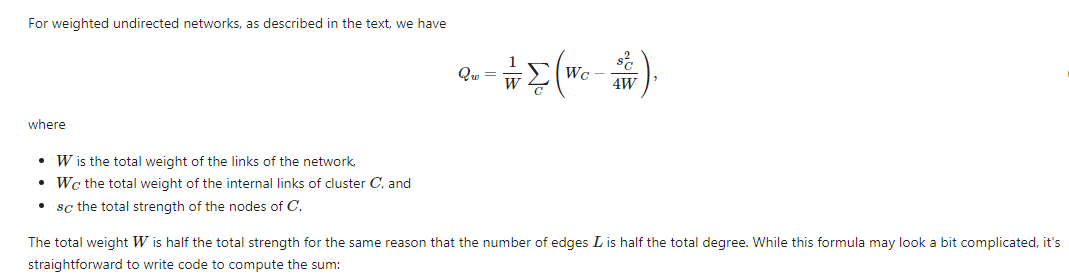

In [11]:
def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # Use subgraph to count only internal links
        C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)
    
    return summation / W

In [12]:
modularity(G, partition)

0.2222222222222222

## 2.2. Compare this to a partition we would suspect to have higher modularity:



In [13]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
modularity(G, partition_2)

0.3888888888888889

## 2.3. NetworkX function


In [14]:
nx.community.quality.modularity(G, partition_2)

0.38888888888888884

# 3. Finding cliques

## 3.1. Construct a graph

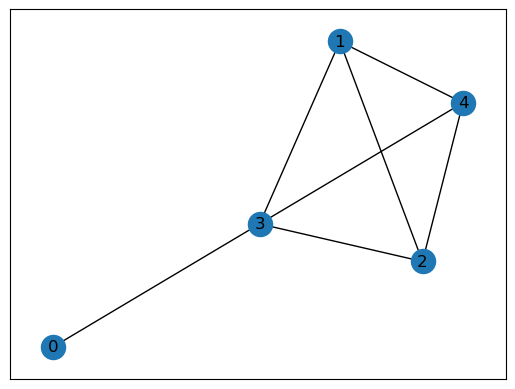

In [16]:
import networkx as nx

G1 = nx.Graph()
edges = [(1, 2), (2, 3), (1, 3), (3, 4), (3, 0),(1, 4),(4, 2)]
G1.add_edges_from(edges)

nx.draw_networkx(G1)

## 3.2. Find all cliques in the graph

In [14]:
res = nx.find_cliques(G1)
cliques = [item for item in res]
cliques = sorted(cliques, key=lambda item: -len(item))
for item in cliques:
    print(item)

[3, 1, 2, 4]
[3, 0]


## 3.3. Find a k-clique

[4, 10, 12]

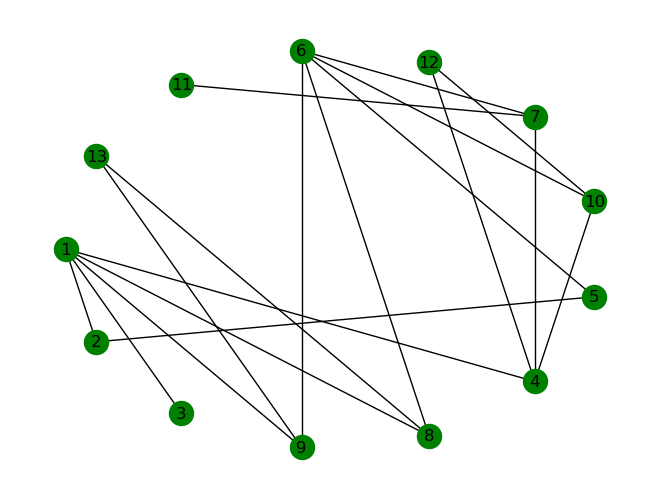

In [15]:
from networkx.algorithms.community import k_clique_communities

G = nx.Graph()
edges = [(1, 2),(1,3), (1,9), (1,8), (1,4), (2,5),(4,10), (4, 7),
         (4,12),(5,6),(6,7),(6,8),(6,9),(6,10),(7,11),(8,13),(9,13),(10,12)]

G.add_edges_from(edges)
nx.draw(G, node_color="green", with_labels = True,pos=nx.shell_layout(G))
c = list(k_clique_communities(G, 3)) # k=3
sorted(list(c[0]))

# 4. Louvain method

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import pandas as pd
import numpy as np
import math

# graph related library
import networkx as nx
from cdlib.algorithms import leiden

#finding the best partition in G using louvain method
import community.community_louvain as cl
partition = cl.best_partition(G)

In [23]:
# import libraries

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import plotly.express as px
import pandas as pd
import numpy as np
import community.community_louvain as community_louvain
import networkx.algorithms.community as nx_comm

## 4.1. Colourize nodes in each partition

In [24]:
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []
    
    # Assign colours to nodes based on community membership
    # Each community gets a distinct colour from the colours list
    # This improves graph visualization by making community structure visually apparent
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

## 4.2. Convert python-louvain package output to NetworkX package community function output format

In [25]:
def get_louvain_communities(graph, random_state=1):
    louvain_partition_dict = community_louvain.best_partition(graph, random_state=random_state)
    unique_partition_labels = list(set(louvain_partition_dict.values()))
    communities = [[] for i in range(len(unique_partition_labels))]
    for node in louvain_partition_dict.keys():
        communities[louvain_partition_dict[node]].append(node)
    return communities

## 4.3. Get communities using Louvain algorithm

In [26]:
louvain_communities = get_louvain_communities(G, random_state=1)
louvain_communities

[[1, 2, 3, 5], [7, 11], [9, 8, 6, 13], [4, 10, 12]]

## 4.4. Visualize community

In [27]:
def visualize_communities(graph, communities):
    # create visualization
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx_comm.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(graph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

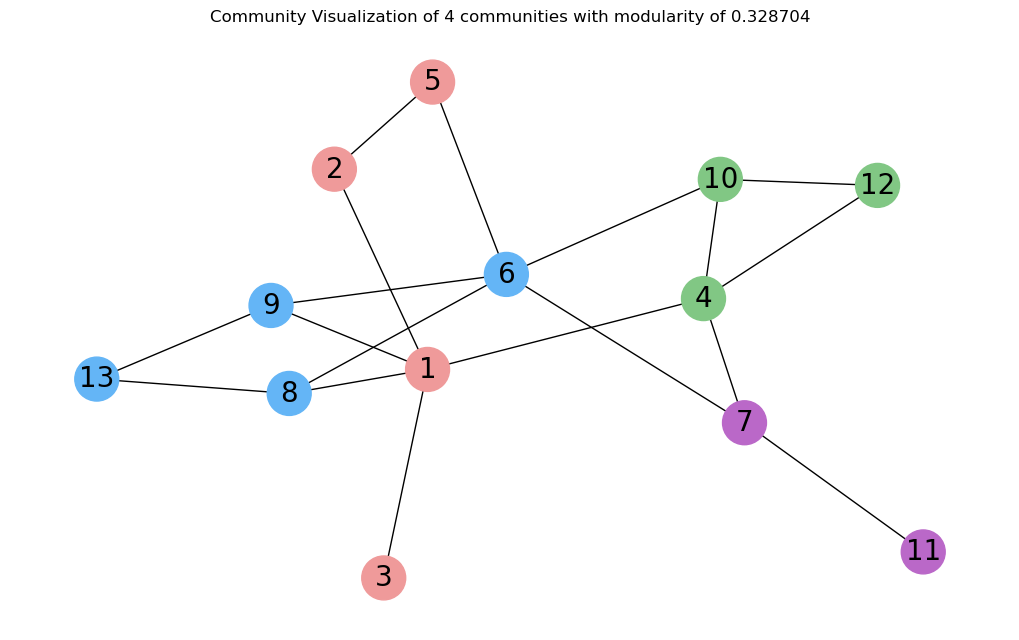

In [28]:
visualize_communities(G, louvain_communities)

# 5. Leiden method

In [29]:
# Convert the leiden package output to NetworkX package community function output format and visualize
def get_visualize_leiden_communities(graph, random_state=1):
    leiden_communities = leiden(G).communities
    node_colors = create_community_node_colors(graph, leiden_communities)
    modularity = round(nx_comm.modularity(graph, leiden_communities), 6)
    print("Leiden communities",leiden_communities)
    title = f"Community Visualization of {len(leiden_communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(graph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

In [33]:
!pip install leidenalg

Leiden communities [[1, 2, 3, 5], [9, 8, 6, 13], [4, 10, 12], [7, 11]]


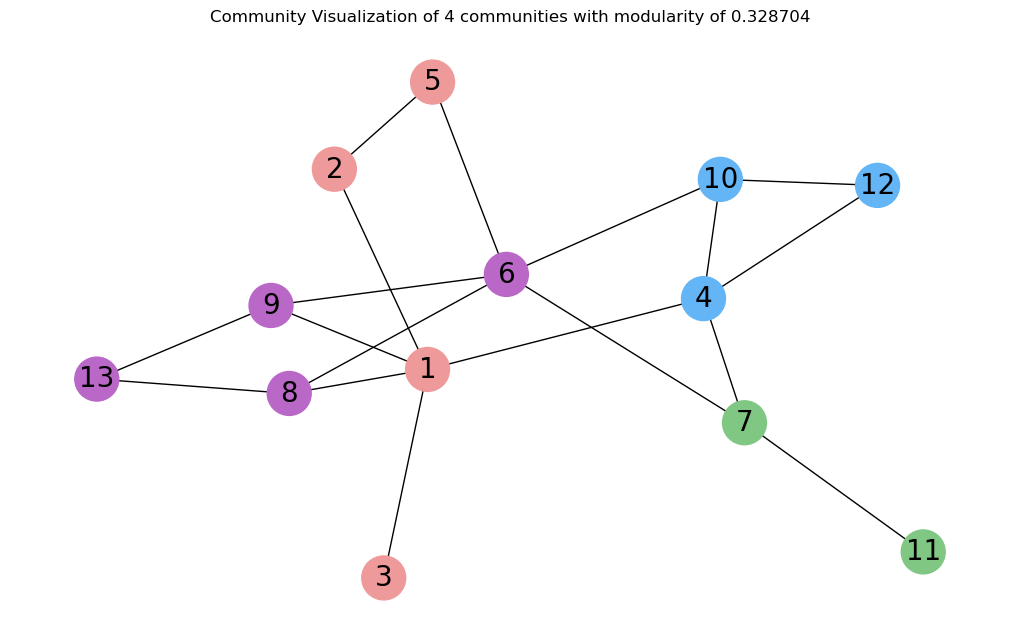

In [32]:
get_visualize_leiden_communities(G)